In [1]:
tiling = [
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
]

In [2]:
n = len(tiling)
m = len(tiling[0])
print(n, m)

8 8


In [3]:
def count_tilings(tiling):
    if ((n + 1) * m * 2 ** m) <= 10000000:
        dp = [[[(0 if k != 0 or j != 0 or mask != 0 else 1) for mask in range(2 ** m)] for j in range(m)] for k in range(n + 1)]
    for k in range(n):
        for j in range(m):
            for mask in range(2 ** m):
                # Вертикальная доминошка
                if k < n - 1 and tiling[k][j] == '.' and tiling[k + 1][j] == '.' and (mask &  (1 << j)) == 0:
                    dp[k + ((j + 1) // m)][(j + 1) % m][mask + (1 << j)] += dp[k][j][mask]
                # Горизонтальная доминошка
                if j < m - 1 and tiling[k][j] == '.' and tiling[k][j + 1] == '.' and (mask & (3 << j)) == 0:
                    dp[k + ((j + 1) // m)][(j + 1) % m][mask + (2 << j)] += dp[k][j][mask]
                # Клетка занята
                if ((1 << j) &  mask) != 0 or tiling[k][j] != '.':
                    dp[k + ((j + 1) // m)][(j + 1) % m][(mask | (1 << j)) - (1 << j)] += dp[k][j][mask]
    return dp

In [4]:
dp = count_tilings(tiling)
print(dp[n][0][0])

12988816


In [80]:
def cover_if_possible(tiling, dp=None):
    if dp is None:
        dp = count_tilings(tiling)
    n = len(dp) - 1
    m = len(dp[0])
    if dp[n][0][0] == 0:
        return None
    
    result = [[-1 if tiling[i][j] == '#' else 0 for j in range(m)] for i in range(n)]
    num = 0
    
    k = n
    j = 0
    mask = 0
    
    while k > 0 or j > 0:
        #print(k, j, mask)
        prev_j = j - 1
        prev_k = k
        if prev_j == -1:
            prev_j += m
            prev_k -= 1
        
        # Начинаем перебирать варианты, каким образом мы могли попасть в i, j, mask
        # Этот вариант очень не оптимален, но занимает меньше кода и все равно быстрее 
        # самого подсчета динамики
        for prev_mask in range(2 ** m):
            if prev_k < n - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k + 1][prev_j] == '.' and \
                (prev_mask & (1 << prev_j)) == 0 and (prev_mask + (1 << prev_j)) == mask and dp[prev_k][prev_j][prev_mask] != 0:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k + 1][prev_j] = num
                #print(f'Vertical at ({prev_k}, {prev_j}) ({prev_k + 1}, {prev_j})')
                num += 1
                break
            elif prev_j < m - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k][prev_j + 1] == '.' and (prev_mask & (3 << prev_j)) == 0 and \
                prev_mask + (2 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] != 0:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k][prev_j + 1] = num
                #print(f'Horisontal at ({prev_k}, {prev_j}) ({prev_k}, {prev_j + 1})')
                num += 1
                break
            elif (((1 << prev_j) & prev_mask) != 0 or tiling[prev_k][prev_j] != '.') and \
                (prev_mask | (1 << prev_j)) - (1 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] != 0:
                mask = prev_mask
                break
        
        j = prev_j
        k = prev_k
    
    return result

In [81]:
def show_tiling(tiling, fill=True, filling=None):
    m = len(tiling[0])
    if fill:
        if filling is None:
            filling = cover_if_possible(tiling)
        if filling is not None:
            for row in filling:
                print(''.join(map(lambda x: '#' if x == -1 else chr(ord('a') + x % (2 * m)), row)))
            return filling
        else:
            print('No tiling')
            return None
    else:
        for row in tiling:
            print(''.join(row))

In [82]:
tiling_no_corners_opposite = [
    '.......#',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '#.......',
]
show_tiling(tiling_no_corners_opposite)

No tiling


In [83]:
tiling_no_corners_same_side = [
    '#.......',
    '........',
    '........',
    '........',
    '........',
    '........',
    '........',
    '#.......',
]
show_tiling(tiling_no_corners_same_side)

#onnmmll
kojjiihh
kgffeedd
cgbbaapp
connmmll
kojjiihh
kgffeedd
#gccbbaa


[[-1, 30, 29, 29, 28, 28, 27, 27],
 [26, 30, 25, 25, 24, 24, 23, 23],
 [26, 22, 21, 21, 20, 20, 19, 19],
 [18, 22, 17, 17, 16, 16, 15, 15],
 [18, 14, 13, 13, 12, 12, 11, 11],
 [10, 14, 9, 9, 8, 8, 7, 7],
 [10, 6, 5, 5, 4, 4, 3, 3],
 [-1, 6, 2, 2, 1, 1, 0, 0]]

In [84]:
tiling_random = [
    '........',
    '#.#.....',
    '..#.....',
    '........',
    '........',
    '........',
    '........',
    '...#....'
]
filling_random = show_tiling(tiling_random)

nnmmllkk
#j#ihhgg
fj#ieedd
fcbbaapp
ocnnmmll
okjjiihh
gkffeedd
gcc#bbaa


In [49]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [89]:
plt.rcParams["figure.figsize"] = [11,11]
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
names = [name for hsv, name in by_hsv if name not in {'black', 'k', 'w', 'white'}]
import random
random.shuffle(names)
names.append('white')
names.append('black')

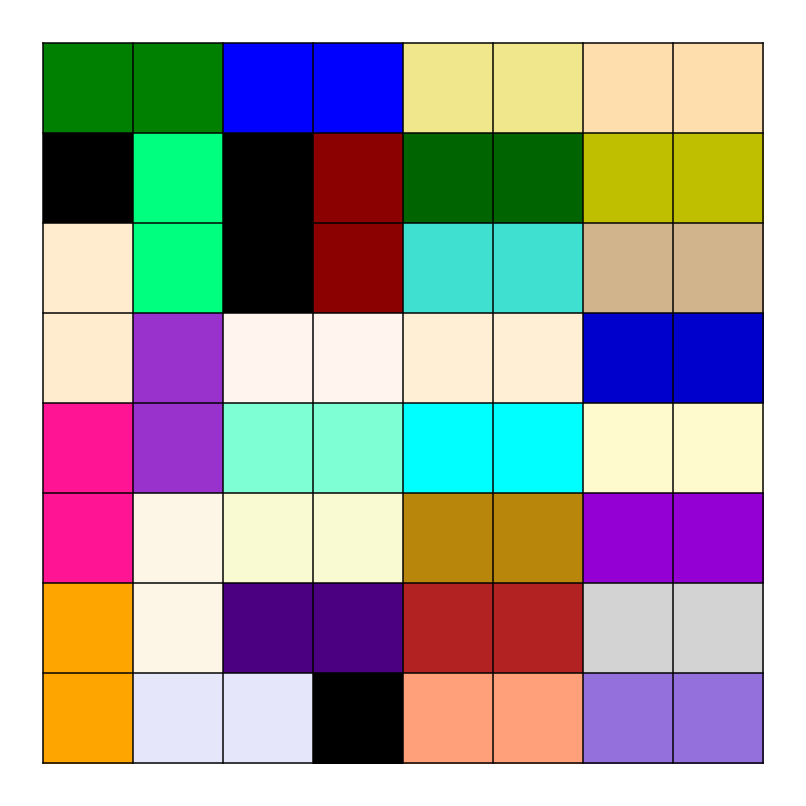

In [184]:
def fill_cell(i, j, color, ax):
    ax.fill([i, i, i + 1, i + 1, i], [j, j + 1, j + 1, j, j], color=color)

def draw_filling(filling):
    if filling is not None:
        fig = plt.figure()
        
        ax = fig.add_axes([0, 0, 1, 1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)      
        
        for name, spine in ax.spines.items():
            spine.set_visible(False)
            spine.set_visible(False)
        
        for i, row in enumerate(filling):
            i = n - i - 1
            for j, cell in enumerate(row):
                fill_cell(j, i, names[cell], ax)

        for i in range(n + 1):
            ax.plot([0, m], [i, i], color='black')
        for i in range(n + 1):
            ax.plot([i, i], [0, n], color='black')
        return fig
    else:
        return None

draw_filling(filling_random)

In [109]:
def maxmimum_cover(tiling):
    if ((n + 1) * m * 2 ** m) <= 10000000:
        dp = [[[(n * m if k != 0 or j != 0 or mask != 0 else 0) for mask in range(2 ** m)] for j in range(m)] for k in range(n + 1)]
    for k in range(n):
        for j in range(m):
            for mask in range(2 ** m):
                next_k, next_j = k + ((j + 1) // m), (j + 1) % m
                # Вертикальная доминошка
                if k < n - 1 and tiling[k][j] == '.' and tiling[k + 1][j] == '.' and (mask &  (1 << j)) == 0:
                    dp[next_k][next_j][mask + (1 << j)] = min(dp[next_k][next_j][mask + (1 << j)], dp[k][j][mask])
                # Горизонтальная доминошка
                if j < m - 1 and tiling[k][j] == '.' and tiling[k][j + 1] == '.' and (mask & (3 << j)) == 0:
                    dp[next_k][next_j][mask + (2 << j)] = min(dp[next_k][next_j][mask + (2 << j)], dp[k][j][mask])
                # Клетка занята
                if ((1 << j) &  mask) != 0 or tiling[k][j] != '.':
                    dp[next_k][next_j][(mask | (1 << j)) - (1 << j)] = \
                        min(dp[next_k][next_j][(mask | (1 << j)) - (1 << j)], dp[k][j][mask])
                # Клетка не занята, рассмотриваем случай её пропуска
                else:
                    dp[next_k][next_j][(mask | (1 << j)) - (1 << j)] = \
                        min(dp[next_k][next_j][(mask | (1 << j)) - (1 << j)], dp[k][j][mask] + 1)
    return dp

def cover_maximum_possible(tiling, dp=None):
    if dp is None:
        dp = maxmimum_cover(tiling)
    n = len(dp) - 1
    m = len(dp[0])

    result = [[-1 if tiling[i][j] == '#' else -2 for j in range(m)] for i in range(n)]
    num = 0
    
    k = n
    j = 0
    mask = 0
    
    while k > 0 or j > 0:
        #print(k, j, mask)
        prev_j = j - 1
        prev_k = k
        if prev_j == -1:
            prev_j += m
            prev_k -= 1
        
        # Начинаем перебирать варианты, каким образом мы могли попасть в i, j, mask
        # Этот вариант очень не оптимален, но занимает меньше кода и все равно быстрее 
        # самого подсчета динамики
        for prev_mask in range(2 ** m):
            # Раньше мы здесь проверяли, что количество вариантов в этой ветке не 0, сейчас нужно
            # проверить, что эта ветка ведет к максимальному покрытию
            if prev_k < n - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k + 1][prev_j] == '.' and \
                    (prev_mask & (1 << prev_j)) == 0 and (prev_mask + (1 << prev_j)) == mask and \
                    dp[prev_k][prev_j][prev_mask] == dp[k][j][mask]:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k + 1][prev_j] = num
                num += 1
                break
            elif prev_j < m - 1 and tiling[prev_k][prev_j] == '.' and tiling[prev_k][prev_j + 1] == '.' and (prev_mask & (3 << prev_j)) == 0 and \
                    prev_mask + (2 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] == dp[k][j][mask]:
                mask = prev_mask
                result[prev_k][prev_j] = num
                result[prev_k][prev_j + 1] = num
                num += 1
                break
            elif (((1 << prev_j) & prev_mask) != 0 or tiling[prev_k][prev_j] != '.') and \
                    (prev_mask | (1 << prev_j)) - (1 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] == dp[k][j][mask]:
                mask = prev_mask
                break
            elif ((1 << prev_j) & prev_mask) == 0 and tiling[prev_k][prev_j] == '.' and \
                    (prev_mask | (1 << prev_j)) - (1 << prev_j) == mask and dp[prev_k][prev_j][prev_mask] + 1 == dp[k][j][mask]:
                mask = prev_mask
                break
                
        
        j = prev_j
        k = prev_k
    
    return result

[[29, 29, 28, 28, 27, 27, 26, 26], [-1, 25, -1, 24, 23, 23, 22, 22], [21, 25, -1, 24, 20, 20, 19, 19], [21, 18, 17, 17, 16, 16, 15, 15], [14, 18, 13, 13, 12, 12, 11, 11], [14, 10, 9, 9, 8, 8, 7, 7], [6, 10, 5, 5, 4, 4, 3, 3], [6, 2, 2, -1, 1, 1, 0, 0]]


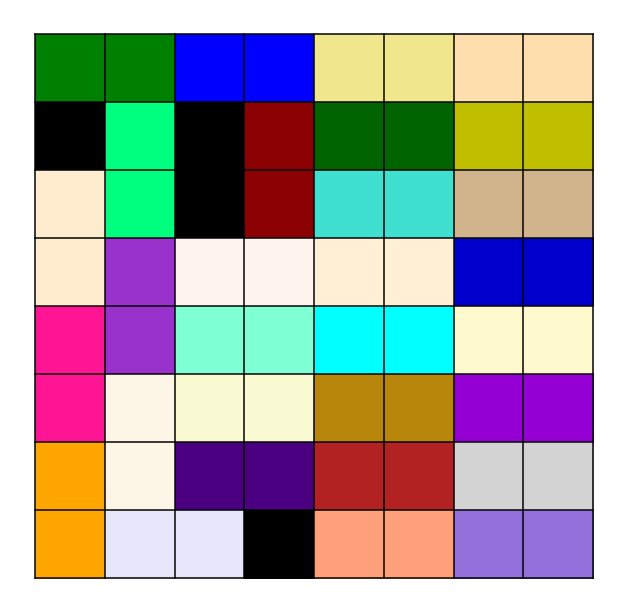

In [110]:
filling = cover_maximum_possible(tiling_random)
print(filling)
draw_filling(filling)

In [102]:
from animation_utils.animation import animate_list

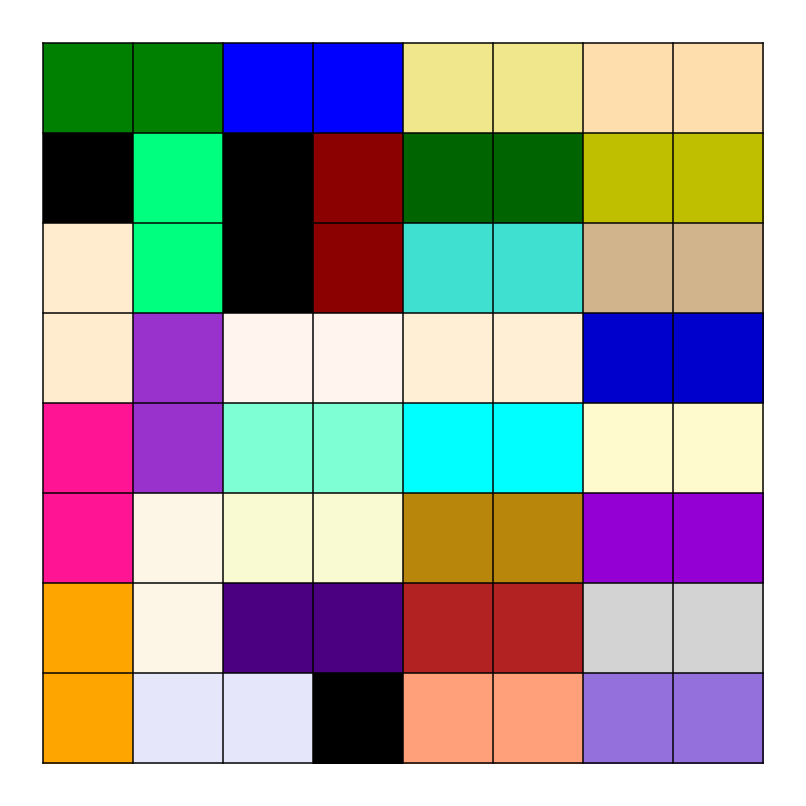

In [181]:
result = draw_filling(cover_maximum_possible(tiling_random))